# Choosing an Optimal Route using Fairfax OpenGIS
#### Robert Schroder rtschroder@fcps.edu 

In [171]:
import io
import zipfile
import requests
import networkx as nx
import numpy as np
import pandas as pd
import json
import smopy
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [172]:
#g = nx.read_shp('data/tl_2019_51059_roads.shp')    #Census
#g = nx.read_shp('data/tl_2019_51_prisecroads.shp') #Census
#g = nx.read_shp('data/tl_2013_06_prisecroads.shp') #Census
g = nx.read_shp('data/Roadway_Centerlines.shp') # https://data-fairfaxcountygis.opendata.arcgis.com/datasets/roadway-centerlines

In [173]:
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)

In [174]:
sgs = list(connected_component_subgraphs(
    g.to_undirected()))
i = np.argmax([len(sg) for sg in sgs])
sg = sgs[i]
len(sg)

108551

In [175]:
pos0 = (38.8122,-77.4493)
pos1 = (38.8252,-77.4106)
#pos0 = (36.6026, -121.9026)
#pos1 = (34.0569, -118.2427)

In [176]:
def get_path(n0, n1):
    """If n0 and n1 are connected nodes in the graph,
    this function returns an array of point
    coordinates along the road linking these two
    nodes."""
    return np.array(json.loads(sg[n0][n1]['Json'])
                    ['coordinates'])

In [177]:
# from https://stackoverflow.com/a/8859667/1595060
EARTH_R = 6372.8

def geocalc(lat0, lon0, lat1, lon1):
    """Return the distance (in km) between two points
    in geographical coordinates."""
    lat0 = np.radians(lat0)
    lon0 = np.radians(lon0)
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    dlon = lon0 - lon1
    y = np.sqrt((np.cos(lat1) * np.sin(dlon)) ** 2 +
        (np.cos(lat0) * np.sin(lat1) - np.sin(lat0) *
         np.cos(lat1) * np.cos(dlon)) ** 2)
    x = np.sin(lat0) * np.sin(lat1) + \
        np.cos(lat0) * np.cos(lat1) * np.cos(dlon)
    c = np.arctan2(y, x)
    return EARTH_R * c

In [178]:
def get_path_length(path):
    return np.sum(geocalc(path[1:, 1], path[1:, 0],
                          path[:-1, 1], path[:-1, 0]))

In [179]:
# Compute the length of the road segments.
for n0, n1 in sg.edges:
    path = get_path(n0, n1)
    distance = get_path_length(path)
    sg.edges[n0, n1]['distance'] = distance

In [180]:
nodes = np.array(sg.nodes())
# Get the closest nodes in the graph.
pos0_i = np.argmin(
    np.sum((nodes[:, ::-1] - pos0)**2, axis=1))
pos1_i = np.argmin(
    np.sum((nodes[:, ::-1] - pos1)**2, axis=1))

In [181]:
# Compute the shortest path.
path = nx.shortest_path(
    sg,
    source=tuple(nodes[pos0_i]),
    target=tuple(nodes[pos1_i]),
    weight='distance')
len(path)

27

In [191]:
roads = pd.DataFrame(
    [sg.edges[path[i], path[i + 1]]
     for i in range(len(path) - 1)],
    columns=['FULLNAME', 'SPEED_LIMIT_CAR',
             'RTTYP', 'distance', 'STATUS'])
roads

,FULLNAME,SPEED_LIMIT_CAR,RTTYP,distance,STATUS
0,OLD CENTREVILLE RD,NaN,NaN,0.080210,BUILT
1,OLD CENTREVILLE RD,NaN,NaN,0.040588,BUILT
2,OLD CENTREVILLE RD,NaN,NaN,0.042658,BUILT
3,OLD CENTREVILLE RD,NaN,NaN,0.087265,BUILT
4,OLD CENTREVILLE RD,NaN,NaN,0.125995,BUILT
5,OLD CENTREVILLE RD,NaN,NaN,0.063614,BUILT
6,OLD CENTREVILLE RD,NaN,NaN,0.184691,BUILT
7,OLD CENTREVILLE RD,NaN,NaN,0.103044,BUILT
8,OLD CENTREVILLE RD,NaN,NaN,0.230764,BUILT
9,OLD CENTREVILLE RD,NaN,NaN,0.005117,BUILT


In [183]:
roads['distance'].sum()

4.819436535651768

In [184]:
m = smopy.Map(pos0, pos1, z=7, margin=.1)

In [185]:
def get_full_path(path):
    """Return the positions along a path."""
    p_list = []
    curp = None
    for i in range(len(path) - 1):
        p = get_path(path[i], path[i + 1])
        if curp is None:
            curp = p
        if (np.sum((p[0] - curp) ** 2) >
                np.sum((p[-1] - curp) ** 2)):
            p = p[::-1, :]
        p_list.append(p)
        curp = p[-1]
    return np.vstack(p_list)

In [186]:
linepath = get_full_path(path)
x, y = m.to_pixels(linepath[:, 1], linepath[:, 0])

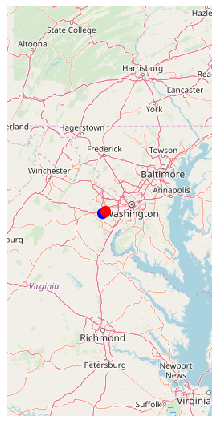

In [187]:
ax = m.show_mpl(figsize=(6, 6))
#plt.rcParams['figure.figsize'] = [10, 10]
# Plot the itinerary.
ax.plot(x, y, '-k', lw=1.5)
# Mark our two positions.
ax.plot(x[0], y[0], 'ob', ms=10)
ax.plot(x[-1], y[-1], 'or', ms=10)